# Introduction

In this project, I'm seeking if a model can correctly predict if a user will skip an ad in an app experience when given the option. The majority of the data used in this model is pulled from a survey given to users before and after interacting with the content. Whether a respondent skipped or not was provided from a separate source which monitored each user's activity while using the app. In the experience, each respondent was exposed to up to 6 ads total and were guaranteed to see 4.

Overall the main purpose of this project is to conduct an exploratory exercise in working with survey data to inform a model. I also used the results to fill in missing data for a small subset of the data where survey data was available but was missing the skip data, so there is possibly a broader business case in using machine learning to help fill in missing data.

In [508]:
# binary classification
import scipy
print('scipy: {}'.format(scipy.__version__)) # numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib
import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__)) # pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

import datetime
#import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

scipy: 0.19.0
numpy: 1.12.1
matplotlib: 2.0.2
pandas: 0.20.1
sklearn: 0.18.1


## Exploratory Data Analysis

In [509]:
train_x = pd.read_excel("../belen/data.xlsx", sheetname='train_x')
train_y = pd.read_excel("../belen/data.xlsx", sheetname='train_y')
test_x = pd.read_excel("../belen/data.xlsx", sheetname='test_x')
test_y = pd.read_excel("../belen/data.xlsx", sheetname='test_y')
data_dictionary = pd.read_excel("../belen/skip_data_dictionary.xlsx")

In [510]:
data_dictionary

,label,question,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,duration_seconds,Duration (in seconds),NaN,NaN,NaN,NaN,NaN
1,date_recorded,Recorded Date,NaN,NaN,NaN,NaN,NaN
2,user_language,User Language,NaN,NaN,NaN,NaN,NaN
3,cell,Survey Cell,NaN,NaN,NaN,NaN,NaN
4,gender,What is your gender?,1=male,2=female,NaN,NaN,NaN
5,age,What is your current age?,NaN,NaN,NaN,NaN,NaN
6,content_usage_music,How often do you do the following on your comp...,5=daily,4=few times a week,3=few times a month,2=once a month,1=never
7,content_usage_video,How often do you do the following on your comp...,5=daily,4=few times a week,3=few times a month,2=once a month,1=never
8,content_usage_movies_tv,How often do you do the following on your comp...,5=daily,4=few times a week,3=few times a month,2=once a month,1=never
9,content_usage_podcast,How often do you do the following on your comp...,5=daily,4=few times a week,3=few times a month,2=once a month,1=never


In [511]:
train_x.head()

,duration_seconds,date_recorded,user_language,cell,gender,age,content_usage_music,content_usage_video,content_usage_movies_tv,content_usage_podcast,...,profile_goods_2,profile_ads_1,profile_ads_2,marital,kids,education,student,employment,income,altRID
0,22937,2017-10-27 16:56:00,EN,1,2,47,4,4,4,1,...,4,3,4,2,1,4,0,1,8,SAFUMO
1,1662,2017-10-27 17:25:00,EN,1,1,24,5,5,5,5,...,5,5,1,1,0,4,0,1,2,LXGYDY
2,24427,2017-10-27 17:26:00,EN,1,2,24,5,3,4,1,...,2,4,2,1,0,5,1,1,2,FORCCF
3,7113,2017-10-27 19:26:00,EN,1,2,25,5,5,5,4,...,1,3,5,2,1,5,1,1,5,ZBWEDR
4,2203,2017-10-27 20:04:00,EN,1,2,46,4,4,3,1,...,2,5,4,1,0,5,0,1,5,AIVXBW


In [512]:
train_y.head()

,altRID,skipped
0,SAFUMO,0
1,LXGYDY,1
2,FORCCF,1
3,ZBWEDR,1
4,AIVXBW,1


In [513]:
pd.Series.equals(train_x.altRID, train_y.altRID)

True

In [514]:
train_x.dtypes

duration_seconds                    int64
date_recorded              datetime64[ns]
user_language                      object
cell                                int64
gender                              int64
age                                 int64
content_usage_music                 int64
content_usage_video                 int64
content_usage_movies_tv             int64
content_usage_podcast               int64
user_history_app                    int64
overall_exp_rating                  int64
app_usage_intent                    int64
recall_num_ads                      int64
exp_app_percep                      int64
ad_attributes_relevant              int64
ad_attributes_intrusive             int64
profile_goods_1                     int64
profile_goods_2                     int64
profile_ads_1                       int64
profile_ads_2                       int64
marital                             int64
kids                                int64
education                         

In [515]:
print("train_x.shape {0}  train_y.shape {1}".format(train_x.shape, train_y.shape))

train_x.shape (165, 28)  train_y.shape (165, 2)


In [516]:
print("test_x.shape {0}  test_y.shape {1}".format(test_x.shape, test_y.shape))

test_x.shape (41, 28)  test_y.shape (41, 2)


In [517]:
# drop redundant info which doesn't contain any variability
train_x.user_language.value_counts()

EN    165
Name: user_language, dtype: int64

In [518]:
test_x.user_language.value_counts()

EN    41
Name: user_language, dtype: int64

In [519]:
print("train_x.shape {0} test_x.shape {1}".format(train_x.shape, test_x.shape))

train_x.shape (165, 28) test_x.shape (41, 28)


In [520]:
# drop non-predictive features, we'll need altRID later to generate target scores
train_x.drop(['date_recorded', 'user_language', 'cell', 'student', 'marital' , 'overall_exp_rating' , 'exp_app_percep' , 'ad_attributes_relevant' , 'ad_attributes_intrusive' , 'kids' , 'altRID'], axis=1, inplace=True)
test_x.drop(['date_recorded', 'user_language', 'cell', 'student', 'marital', 'overall_exp_rating' , 'exp_app_percep' , 'ad_attributes_relevant' , 'ad_attributes_intrusive' , 'kids' , 'altRID'], axis=1, inplace=True)

In [521]:
print("train_x.shape {0} test_x.shape {1}".format(train_x.shape, test_x.shape))

train_x.shape (165, 17) test_x.shape (41, 17)


In [522]:
# check summary stats of train vs test
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
print(train_x.describe())

       duration_seconds   gender      age  content_usage_music  content_usage_video  \
count           165.000  165.000  165.000              165.000              165.000   
mean           6620.976    1.491   35.679                4.576                4.606   
std            4825.847    0.501    8.082                0.691                0.696   
min            1070.000    1.000   21.000                2.000                2.000   
25%            3246.000    1.000   29.000                4.000                4.000   
50%            4910.000    1.000   36.000                5.000                5.000   
75%            8538.000    2.000   41.000                5.000                5.000   
max           24427.000    2.000   54.000                5.000                5.000   

       content_usage_movies_tv  content_usage_podcast  user_history_app  app_usage_intent  \
count                  165.000                165.000           165.000           165.000   
mean                     4.545

In [523]:
print(test_x.describe())

       duration_seconds  gender     age  content_usage_music  content_usage_video  \
count            41.000  41.000  41.000               41.000               41.000   
mean           4503.390   1.463  36.268                4.488                4.537   
std            3003.933   0.505   7.162                0.746                0.778   
min            1191.000   1.000  24.000                2.000                2.000   
25%            3061.000   1.000  29.000                4.000                4.000   
50%            3548.000   1.000  35.000                5.000                5.000   
75%            4539.000   2.000  42.000                5.000                5.000   
max           15685.000   2.000  51.000                5.000                5.000   

       content_usage_movies_tv  content_usage_podcast  user_history_app  app_usage_intent  \
count                   41.000                 41.000            41.000            41.000   
mean                     4.561                  

In [524]:
# train vs test sample data distribution

# large right skew
print('Mean and median duration_seconds are %0.f and %0.f'%(train_x.duration_seconds.mean(), test_x.duration_seconds.median()))

# no skew
print('Mean and median age are %0.f and %0.f'%(train_x.age.mean(), test_x.age.median()))

# slight right skew
print('Mean and median content_usage_music are %0.f and %0.f'%(train_x.content_usage_music.mean(), test_x.content_usage_music.median()))

# no skew
print('Mean and median content_usage_video are %0.f and %0.f'%(train_x.content_usage_video.mean(), test_x.content_usage_video.median()))

# no skew
print('Mean and median content_usage_movies_tv are %0.f and %0.f'%(train_x.content_usage_movies_tv.mean(), test_x.content_usage_movies_tv.median()))

# no skew
print('Mean and median content_usage_podcast are %0.f and %0.f'%(train_x.content_usage_podcast.mean(), test_x.content_usage_podcast.median()))

# no skew
print('Mean and median user_history_app are %0.f and %0.f'%(train_x.user_history_app.mean(), test_x.user_history_app.median()))


Mean and median duration_seconds are 6621 and 3548
Mean and median age are 36 and 35
Mean and median content_usage_music are 5 and 5
Mean and median content_usage_video are 5 and 5
Mean and median content_usage_movies_tv are 5 and 5
Mean and median content_usage_podcast are 3 and 3
Mean and median user_history_app are 1 and 0


In [525]:
# positive (right), zero show less skew and negative (left) skew
skew = train_x.skew()
print(skew)

duration_seconds           1.512
gender                     0.037
age                        0.220
content_usage_music       -1.904
content_usage_video       -1.926
content_usage_movies_tv   -2.134
content_usage_podcast      0.094
user_history_app           0.573
app_usage_intent           2.601
recall_num_ads             1.632
profile_goods_1           -0.518
profile_goods_2           -0.162
profile_ads_1             -0.187
profile_ads_2             -0.560
education                 -0.241
employment                 2.178
income                    -0.237
dtype: float64


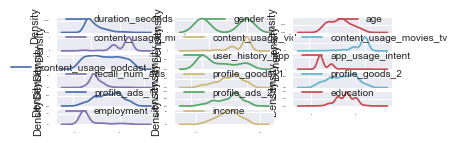

In [526]:
# density
train_x.plot(kind='density', subplots=True, layout=(12,3), sharex=False, legend=True, fontsize=2)
plt.show()

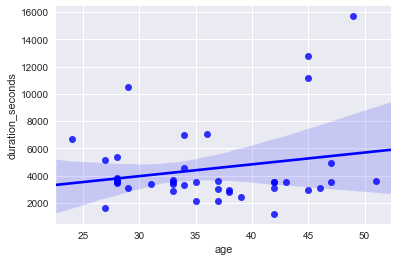

In [527]:
sns.regplot(x = 'age', y = 'duration_seconds', data = test_x, color = 'blue');

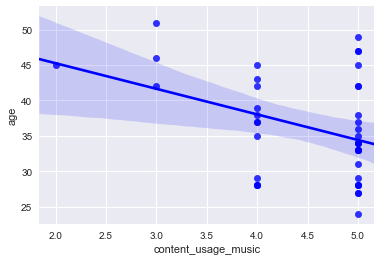

In [528]:
sns.regplot(x = 'content_usage_music', y = 'age', data = test_x, color = 'blue');

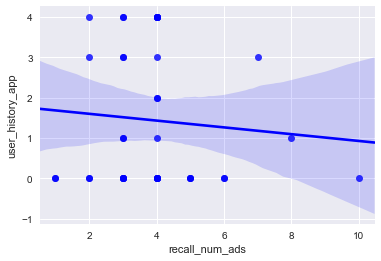

In [529]:
sns.regplot(x = 'recall_num_ads', y = 'user_history_app', data = test_x, color = 'blue');

<module 'matplotlib.pyplot' from 'C:\\Users\\fibe6002\\AppData\\Local\\Continuum\\Anaconda1\\lib\\site-packages\\matplotlib\\pyplot.py'>

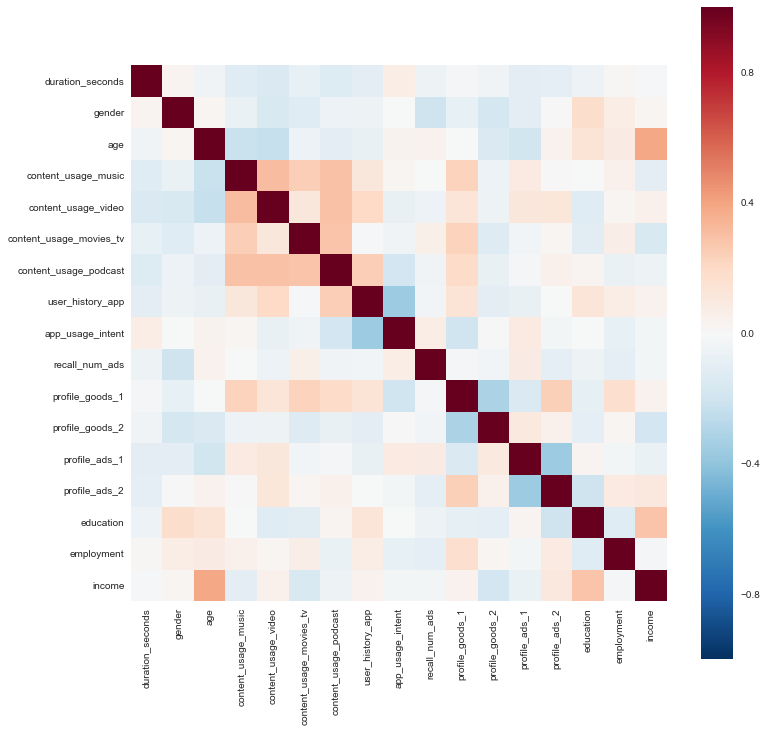

In [530]:
corr = train_x.select_dtypes(include = ['float64', 'int64']).iloc[:, :].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)
sns.plt

# some findings
# positive correlations across content usage- music, video, movies and tv, podcasts
# postive correlation between overall_exp_rating and app_usage_intent
# negative correlation between recall_num_ads and overall_exp_rating
# negative correlation between profile_ads_1 (ad avoiders) and profile_ads_2 (use ads to learn about new products)
# negative correlation between ad_attributes_relevant and ad_attributes_intrustive

In [531]:
# how many NaN values there are in each column
len(train_x) - train_x.count()

duration_seconds           0
gender                     0
age                        0
content_usage_music        0
content_usage_video        0
content_usage_movies_tv    0
content_usage_podcast      0
user_history_app           0
app_usage_intent           0
recall_num_ads             0
profile_goods_1            0
profile_goods_2            0
profile_ads_1              0
profile_ads_2              0
education                  0
employment                 0
income                     0
dtype: int64

In [532]:
# class imbalance, 2x more respondents skipped
train_y.skipped.value_counts()

1    110
0     55
Name: skipped, dtype: int64

In [533]:
train_x.recall_num_ads.value_counts()

3     52
4     36
6     20
5     12
2     12
1      9
7      8
8      5
0      4
15     2
9      2
12     1
11     1
10     1
Name: recall_num_ads, dtype: int64

## Feature Engineering

The content usage features are positively correlated so I'm creating an overall content usage "score". I'm applying this first to train and then to test.

In [534]:
train_x['content_usage_score'] = train_x['content_usage_music'] + train_x['content_usage_video'] + train_x['content_usage_movies_tv'] + train_x[
    'content_usage_podcast']
train_x.head()

,duration_seconds,gender,age,content_usage_music,content_usage_video,content_usage_movies_tv,content_usage_podcast,user_history_app,app_usage_intent,recall_num_ads,profile_goods_1,profile_goods_2,profile_ads_1,profile_ads_2,education,employment,income,content_usage_score
0,22937,2,47,4,4,4,1,0,2,3,3,4,3,4,4,1,8,13
1,1662,1,24,5,5,5,5,0,1,3,3,5,5,1,4,1,2,20
2,24427,2,24,5,3,4,1,0,1,3,5,2,4,2,5,1,2,13
3,7113,2,25,5,5,5,4,1,1,8,5,1,3,5,5,1,5,19
4,2203,2,46,4,4,3,1,0,1,4,2,2,5,4,5,1,5,12


In [535]:
test_x['content_usage_score'] = test_x['content_usage_music'] + test_x['content_usage_video'] + test_x['content_usage_movies_tv'] + test_x[
    'content_usage_podcast']
test_x.head()

,duration_seconds,gender,age,content_usage_music,content_usage_video,content_usage_movies_tv,content_usage_podcast,user_history_app,app_usage_intent,recall_num_ads,profile_goods_1,profile_goods_2,profile_ads_1,profile_ads_2,education,employment,income,content_usage_score
0,3061,1,42,5,5,5,5,1,1,3,4,2,3,2,3,4,1,20
1,2124,2,35,4,5,5,2,0,4,1,2,2,4,2,5,1,6,16
2,2155,2,37,4,5,5,4,0,2,3,3,3,2,4,5,1,7,18
3,5126,2,27,5,5,5,4,0,1,4,4,5,2,5,3,1,8,19
4,3041,2,37,5,4,4,3,3,1,4,4,2,2,4,5,1,5,16


In [536]:
# dropping content usages
train_x.drop(['content_usage_music', 'content_usage_video', 'content_usage_movies_tv', 'content_usage_podcast'], axis=1, inplace=True)
test_x.drop(['content_usage_music', 'content_usage_video', 'content_usage_movies_tv', 'content_usage_podcast'], axis=1, inplace=True)

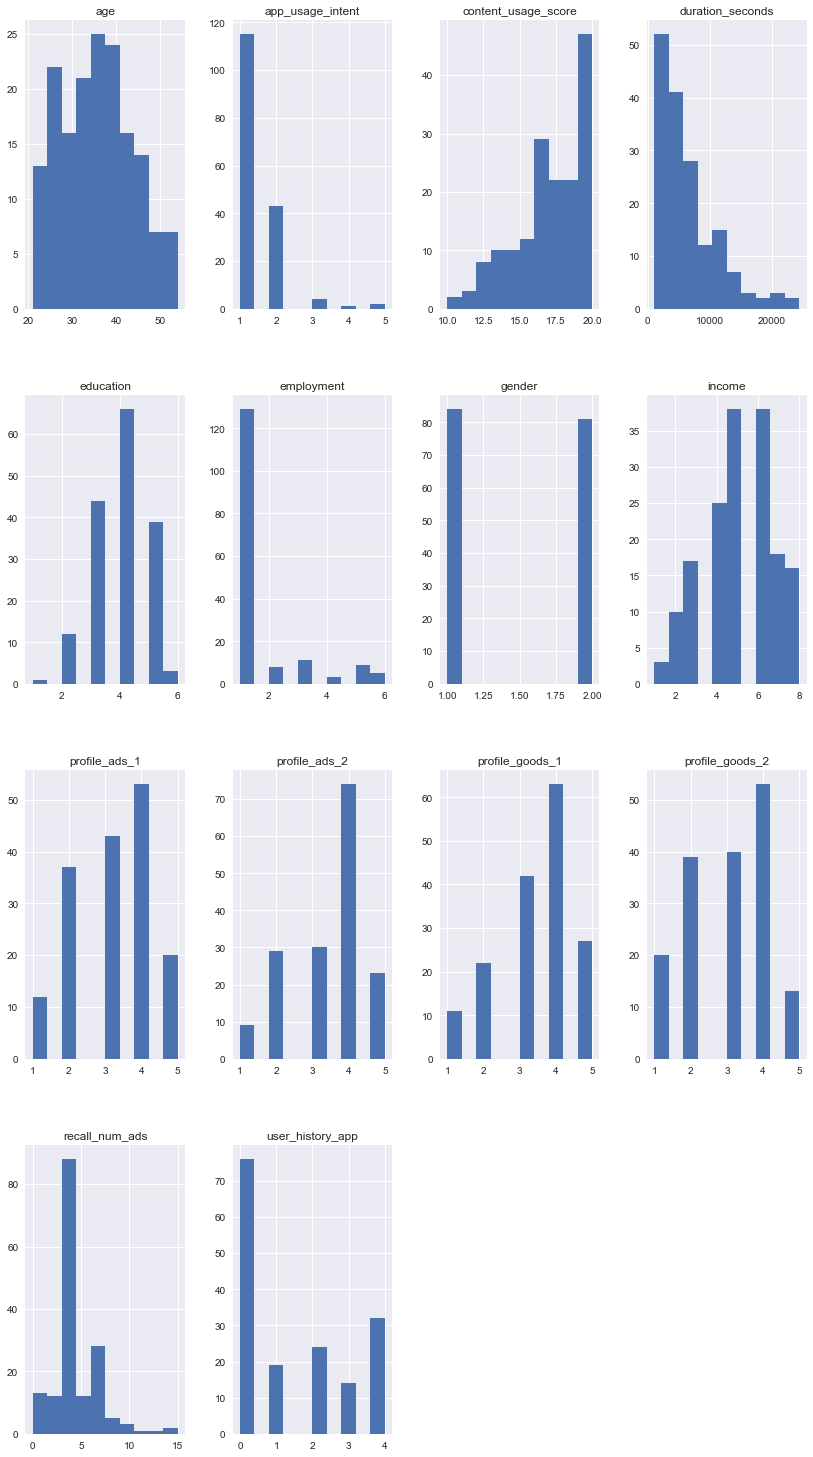

In [537]:
train_x.hist(figsize=(14, 26))
plt.show() 

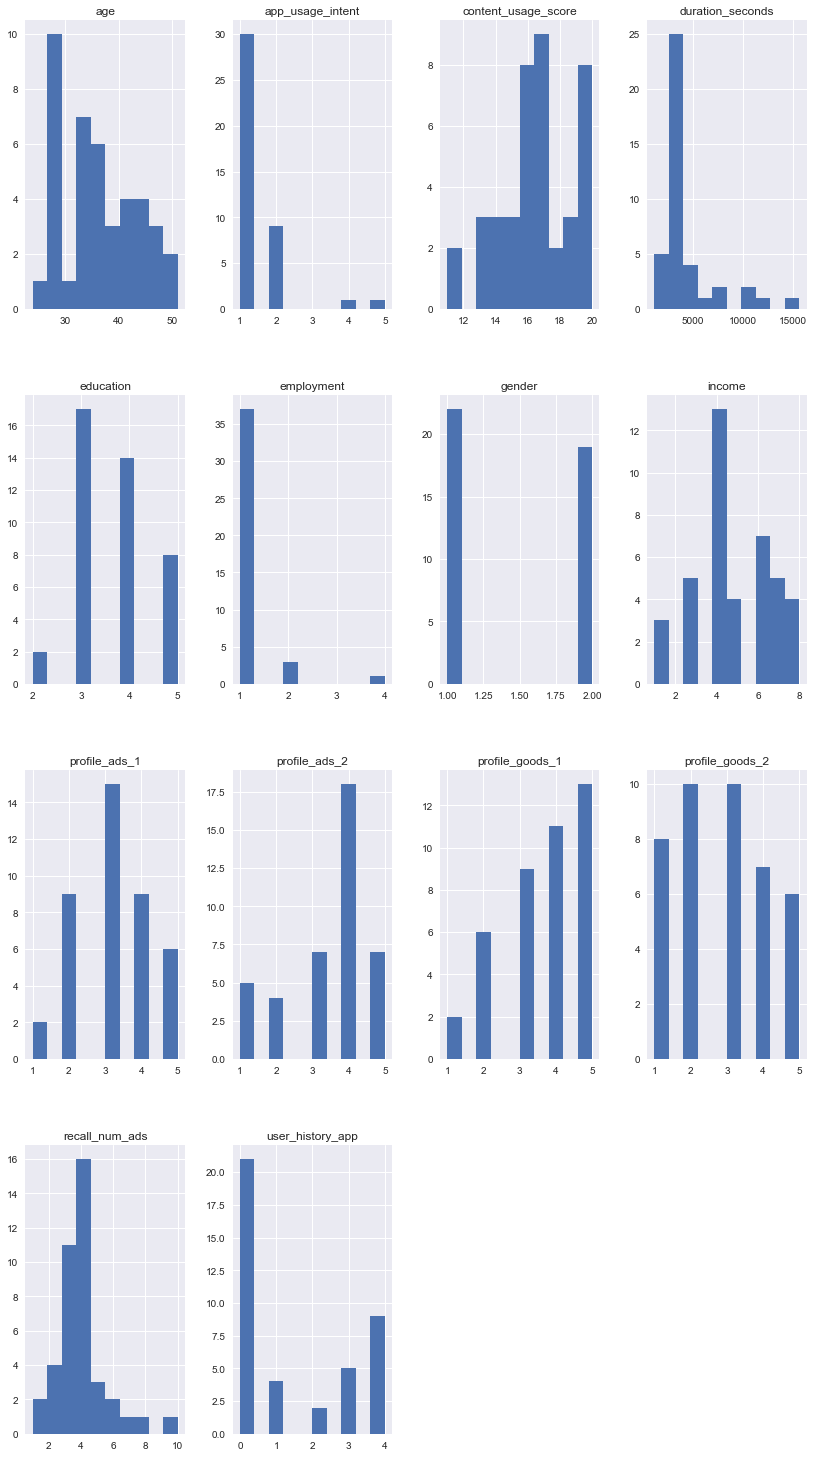

In [538]:
test_x.hist(figsize=(14, 26))
plt.show() 

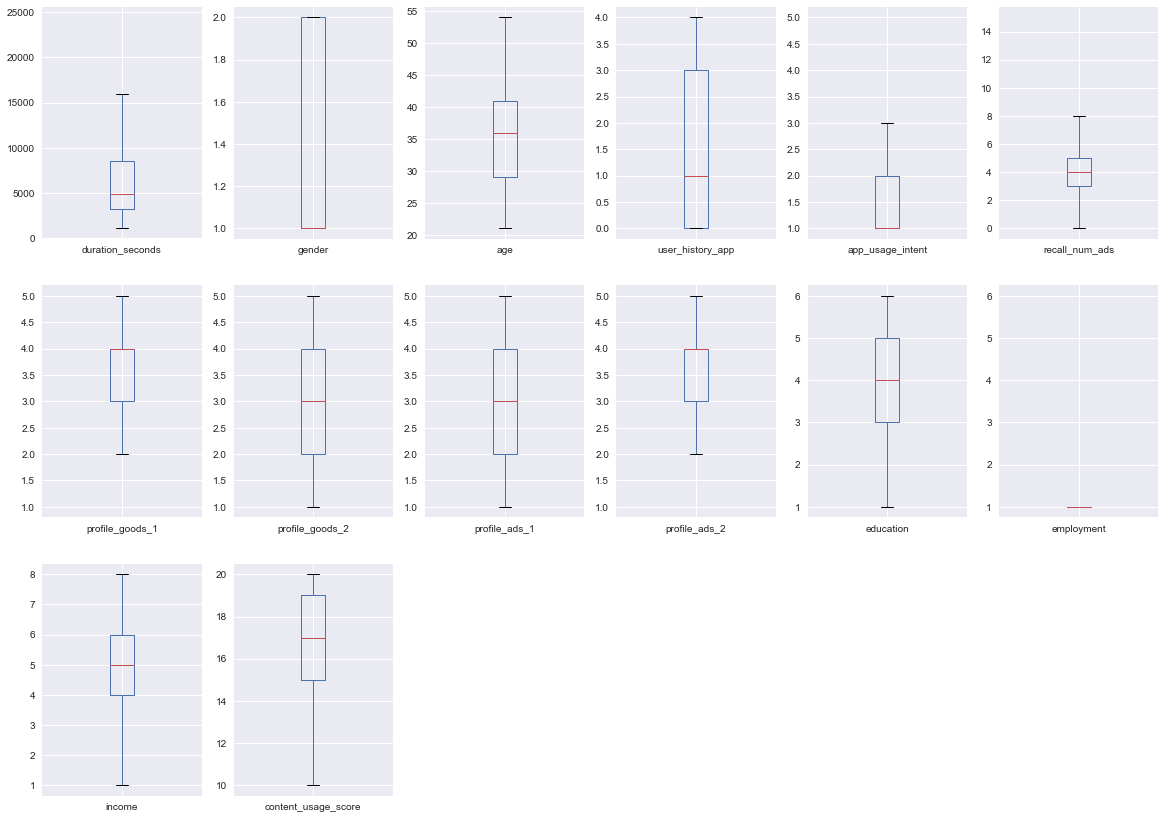

In [539]:
train_x.plot(kind='box', subplots=True, figsize=(20, 35), layout=(7,6), sharex=False, sharey=False) 
plt.show()

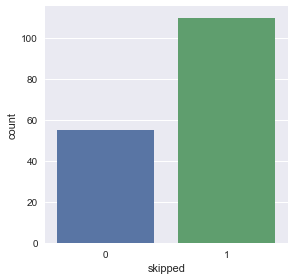

In [540]:
#2x more skipped
sns.factorplot('skipped', data=train_y, kind='count')

In [541]:
train_x.columns

Index(['duration_seconds', 'gender', 'age', 'user_history_app', 'app_usage_intent',
       'recall_num_ads', 'profile_goods_1', 'profile_goods_2', 'profile_ads_1', 'profile_ads_2',
       'education', 'employment', 'income', 'content_usage_score'],
      dtype='object')

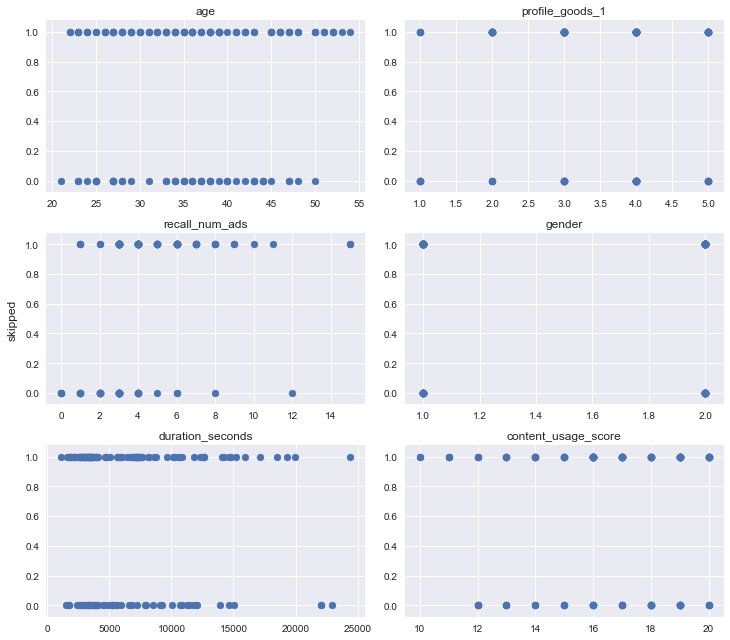

In [542]:
plt.figure(1)
f, axarr = plt.subplots(3, 2, figsize=(10, 9))
skipped = train_y.skipped.values
axarr[0, 0].scatter(train_x.age.values, skipped)
axarr[0, 0].set_title('age')
axarr[0, 1].scatter(train_x.profile_goods_1.values, skipped)
axarr[0, 1].set_title('profile_goods_1')
axarr[1, 0].scatter(train_x.recall_num_ads.values, skipped)
axarr[1, 0].set_title('recall_num_ads')
axarr[1, 1].scatter(train_x.gender.values, skipped)
axarr[1, 1].set_title('gender')
axarr[2, 0].scatter(train_x.duration_seconds, skipped)
axarr[2, 0].set_title('duration_seconds')
axarr[2, 1].scatter(train_x.content_usage_score, skipped)
axarr[2, 1].set_title('content_usage_score')




f.text(-0.01, 0.5, 'skipped', va='center', rotation='vertical', fontsize = 12)
plt.tight_layout()
plt.show()

In [543]:
train_x.head()

,duration_seconds,gender,age,user_history_app,app_usage_intent,recall_num_ads,profile_goods_1,profile_goods_2,profile_ads_1,profile_ads_2,education,employment,income,content_usage_score
0,22937,2,47,0,2,3,3,4,3,4,4,1,8,13
1,1662,1,24,0,1,3,3,5,5,1,4,1,2,20
2,24427,2,24,0,1,3,5,2,4,2,5,1,2,13
3,7113,2,25,1,1,8,5,1,3,5,5,1,5,19
4,2203,2,46,0,1,4,2,2,5,4,5,1,5,12


## Algorithms Spot Check

In [544]:
from sklearn.linear_model import Lasso, Ridge  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation

# Test options and evaluation metric
num_folds = 10
num_instances = len(train_x) 
seed = 7
scoring = 'roc_auc'

# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LASSO', Lasso())) 
models.append(('Ridge', Ridge())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier())) 
models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, train_x, train_y.skipped, cv=kfold,
        scoring=scoring)
    results.append(cv_results)
    names.append(name)
    model.fit(train_x, train_y.skipped)
    predicted = model.predict(test_x)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.749896 (0.091059)
LASSO: 0.499251 (0.274517)
Ridge: 0.687602 (0.103515)
LDA: 0.686015 (0.102480)
NB: 0.660717 (0.085270)
CART: 0.537129 (0.145868)
KNeighborsClassifier: 0.412090 (0.142994)
AdaBoostClassifier: 0.677793 (0.101282)
RandomForestClassifier: 0.589150 (0.167503)
ExtraTreesClassifier: 0.619819 (0.104673)
GradientBoostingClassifier: 0.702387 (0.114135)


In [545]:
model.feature_importances_
#sort and remove features ranking closer to 0% 

array([ 0.25731297,  0.02448798,  0.12531871,  0.01692668,  0.05090706,
        0.12677161,  0.04073901,  0.05414081,  0.03875124,  0.04201649,
        0.03451992,  0.05413429,  0.06257517,  0.07139804])

In [546]:
train_x.columns

Index(['duration_seconds', 'gender', 'age', 'user_history_app', 'app_usage_intent',
       'recall_num_ads', 'profile_goods_1', 'profile_goods_2', 'profile_ads_1', 'profile_ads_2',
       'education', 'employment', 'income', 'content_usage_score'],
      dtype='object')

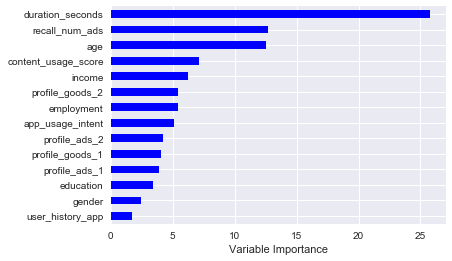

In [547]:
#interesting feature importance chart, doesn't tell you which way the feature impacts the results, just highlights overall importance
#i used this to inform which variables to drop in cell 413
Importance = pd.DataFrame({'Importance' :model.feature_importances_*100}, index=train_x.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='b', )
plt.xlabel('Variable Importance')
plt.gca().legend_= None

In [548]:
# Compare Algorithms
def plot_model_score_distribution(results, names):
    ymin = .1
    ymax = .95
    fig = plt.figure(figsize=(25,10)) 
    fig.suptitle('Algorithm Comparison') 
    ax = fig.add_subplot(111) 
    plt.boxplot(results) 
    ax.set_ylim([ymin,ymax])
    ax.set_xticklabels(names)
    plt.show()

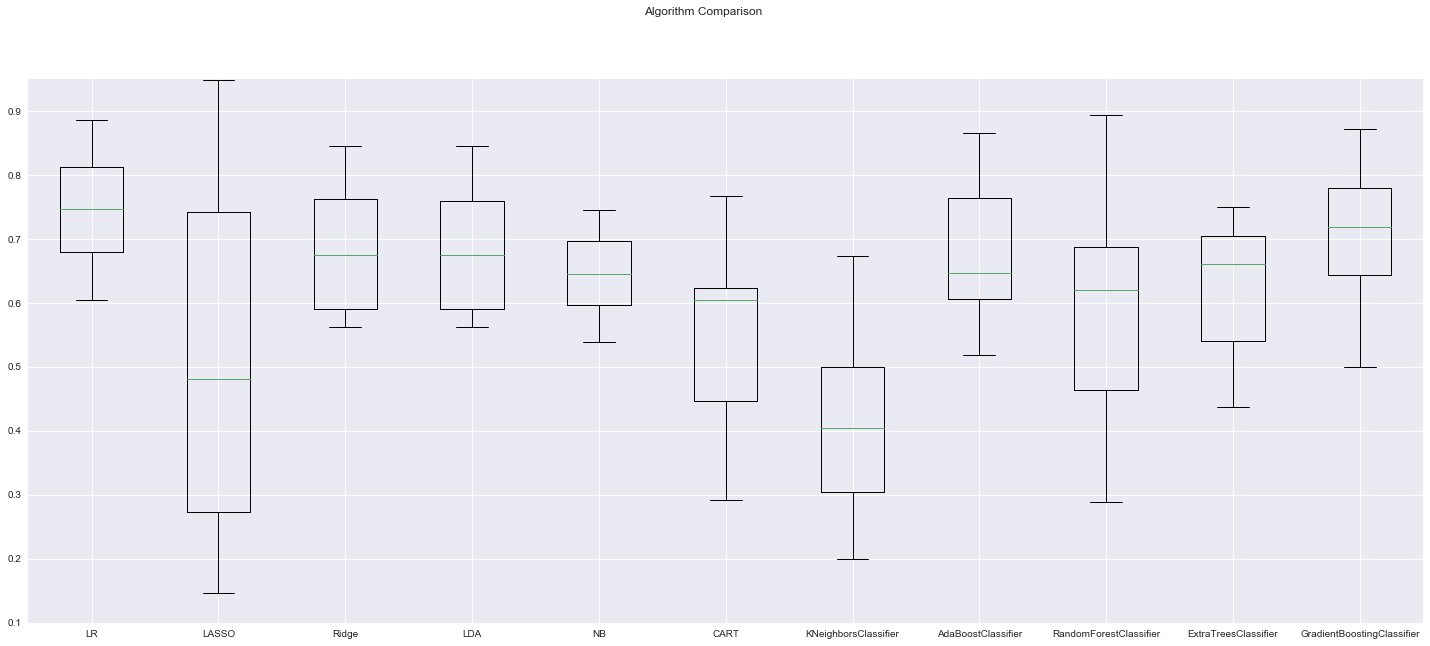

In [549]:
plot_model_score_distribution(results, names)

## Single Model

In [550]:
#need local cross val for tuning below
def local_cv(model, params):
    param_grid = params
    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(train_x, train_y.skipped)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    for params, mean_score, scores in grid_result.grid_scores_:
        print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

## Tune Ridge

In [551]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [552]:
params = {"alpha":[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}
local_cv(Ridge(), params)

Best: 0.716599 using {'alpha': 75}
0.686015 (0.102480) with: {'alpha': 0.05}
0.686015 (0.102480) with: {'alpha': 0.1}
0.686015 (0.102480) with: {'alpha': 0.3}
0.687602 (0.103515) with: {'alpha': 1}
0.687761 (0.102928) with: {'alpha': 3}
0.691351 (0.106543) with: {'alpha': 5}
0.696529 (0.104336) with: {'alpha': 10}
0.693297 (0.104671) with: {'alpha': 15}
0.702763 (0.100621) with: {'alpha': 30}
0.708277 (0.099917) with: {'alpha': 50}
0.715368 (0.093045) with: {'alpha': 75}


## Tune GBM

In [553]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'presort', 'random_state', 'subsample', 'verbose', 'warm_start'])

In [554]:
params = {"max_depth":[2,3,4,10], "n_estimators":[200,300,400]} #params may not be optimal
local_cv(GradientBoostingClassifier(), params)

Best: 0.679825 using {'max_depth': 2, 'n_estimators': 200}
0.679303 (0.107362) with: {'max_depth': 2, 'n_estimators': 200}
0.663512 (0.112881) with: {'max_depth': 2, 'n_estimators': 300}
0.659226 (0.109567) with: {'max_depth': 2, 'n_estimators': 400}
0.679054 (0.122066) with: {'max_depth': 3, 'n_estimators': 200}
0.675878 (0.134793) with: {'max_depth': 3, 'n_estimators': 300}
0.651928 (0.127126) with: {'max_depth': 3, 'n_estimators': 400}
0.655382 (0.124581) with: {'max_depth': 4, 'n_estimators': 200}
0.661975 (0.114857) with: {'max_depth': 4, 'n_estimators': 300}
0.657408 (0.121349) with: {'max_depth': 4, 'n_estimators': 400}
0.639362 (0.181979) with: {'max_depth': 10, 'n_estimators': 200}
0.634621 (0.172476) with: {'max_depth': 10, 'n_estimators': 300}
0.639596 (0.183112) with: {'max_depth': 10, 'n_estimators': 400}


## Multiple Model Ensemble

## Create Ensemble of three best models

In [555]:
estimators = []

model1 = LogisticRegression()
estimators.append(('LR', model1))
model2 = LinearDiscriminantAnalysis()
estimators.append(('LDA', model2))
model3 = GradientBoostingClassifier(n_estimators=300, max_depth=4)
estimators.append(('GradientBoostingClassifier', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft')
results = cross_validation.cross_val_score(ensemble, train_x, train_y.skipped, cv=kfold) 
print(results)
print(results.mean())

ensemble.fit(train_x, train_y.skipped)
ensemble_preds = ensemble.predict(test_x)

#return to LR

[ 0.76470588  0.70588235  0.58823529  0.76470588  0.70588235  0.625       0.6875
  0.75        0.6875      0.8125    ]
0.709191176471


In [556]:
ensemble_preds

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [557]:
submission = pd.DataFrame({"altRID":test_y.altRID, "skipped":ensemble_preds})
submission.to_csv("ensemble_2nd_order_features.csv", index = False)

In [558]:
#could read submission file back into notebook
submission = pd.read_excel("../belen/ensemble_2nd_order_features.xlsx")
submission.head()

,altRID,skipped
0,GENMDZ,1
1,NBBMVA,0
2,MSPEVA,0
3,CXAJUY,0
4,EOVWKS,1


## Findings & Improvements

1. The model ensemble correctly predicted whether a user skipped an ad 68% of the time! 
    
2. Each respondent was served the same number of ads, but perceived ad load (which ranged from 0-10) ranked highest in feature importance.
3. Model accuracy may be improved by removing additional nonpredictive & highly correlated features (e.g. content_usage_podcast, gender)
4. Additional sample may help overcome case imbalance (2x more respondents skipped).
